<a href="https://colab.research.google.com/github/srikrish2812/pytorch_practice/blob/main/torch_2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch NN Classification

## 1. Make classification data and get it ready - Toy Data

In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd


In [2]:
n_samples = 1000
X,y = make_circles(n_samples, noise=0.03,
                   random_state=42)
print(len(X), len(y))
X[:5], y[:5]

1000 1000


(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


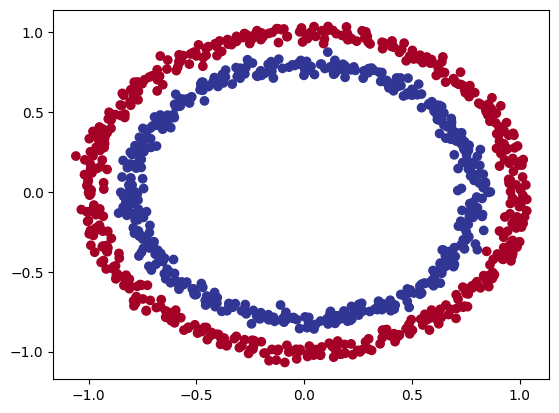

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y =X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Checking input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)

[0.75424625 0.23148074] 1


### 1.2 Turn data to tensors and create train and test splits

In [7]:
import torch
torch.__version__

'2.5.1+cu124'

In [8]:
X.dtype

dtype('float64')

In [9]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Building a model

1. Setup device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimizer

### 2.1 Setup device agnostic code

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2.2 Create a model by:-

- Subclass `nn.Module`
- Create 2 `nn.Linear()` layers that are capable of handling shapes of our data
- Defines a `forward()` method that outlines the forward pass of the model
- Instatiate an instance of our model class and send it to the target device

In [12]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2,
        #                          out_features=5)
        # self.layer_2 = nn.Linear(in_features=5,
        #                          out_features=1)
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self,x):
        return self.two_linear_layers(x)

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [13]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [104]:
# lets replicate the above model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [105]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('1.bias', tensor([-0.2060], device='cuda:0'))])

In [106]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(len(untrained_preds), untrained_preds.shape)
    print(len(X_test), X_test.shape)
    print(untrained_preds[:10])
    print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200, 2])
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


### 2.3 Loss function and Optimizer declaration

In [107]:
loss_fn = nn.BCEWithLogitsLoss() # combines both sigmoid and nn.BCELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [108]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Build a Training Loop and Testing Loop

**Training Loop:**

- Forward pass
- Loss computation
- Zero the optimizer gradients
- Backpropagate the loss
- Optimizer step

### 3.1 Going from raw logits -> prediction probs -> prediction labels

Our model outputs are going to be raw logits and we convert these logits in to prediction probabilities by passing them to some kind of activation function depending on the problem. Then we convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [109]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(y_logits)


tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')


In [110]:
# use sigmoids to convert them to prediction probs
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)
print(torch.round(y_pred_probs))
#print(y_preds)
print(y_test[:5])

y_preds = torch.round(y_pred_probs)
# now lets do it in full
model_0.eval()
with torch.inference_mode():
    # logits -> prediction probs -> prediction labels
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

## check for equality

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([1., 0., 1., 0., 1.], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')


In [111]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Build a training loop

In [112]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    # logits -> prediction probs -> labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    # nn.BCEWithLogitsLoss() takes logits as input
    loss = loss_fn(
        y_logits, y_train
    )
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Backpropagate the loss
    loss.backward()

    # 5. Step the optimizer grads (gradient descent)
    optimizer.step()

    # TEsting Loop
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(
            y_true=y_test,
            y_pred = test_pred
        )

    # print what's happening
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69569 | Acc: 50.00% | Test Loss: 0.69721, Test Acc: 50.00%
Epoch: 10 | Loss: 0.69403 | Acc: 50.00% | Test Loss: 0.69615, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69343 | Acc: 46.00% | Test Loss: 0.69585, Test Acc: 48.50%
Epoch: 30 | Loss: 0.69321 | Acc: 49.00% | Test Loss: 0.69577, Test Acc: 47.50%
Epoch: 40 | Loss: 0.69312 | Acc: 49.50% | Test Loss: 0.69573, Test Acc: 46.50%
Epoch: 50 | Loss: 0.69308 | Acc: 50.38% | Test Loss: 0.69569, Test Acc: 46.50%
Epoch: 60 | Loss: 0.69306 | Acc: 50.50% | Test Loss: 0.69564, Test Acc: 46.50%
Epoch: 70 | Loss: 0.69305 | Acc: 50.50% | Test Loss: 0.69559, Test Acc: 46.50%
Epoch: 80 | Loss: 0.69304 | Acc: 50.75% | Test Loss: 0.69553, Test Acc: 46.50%
Epoch: 90 | Loss: 0.69303 | Acc: 50.38% | Test Loss: 0.69547, Test Acc: 46.50%


## 3.3 Make prediction and visualize

TO do this we use an helper function called `plot_decision_boundary()` that we import from github : https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [113]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("The file already exists, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

The file already exists, skipping download...


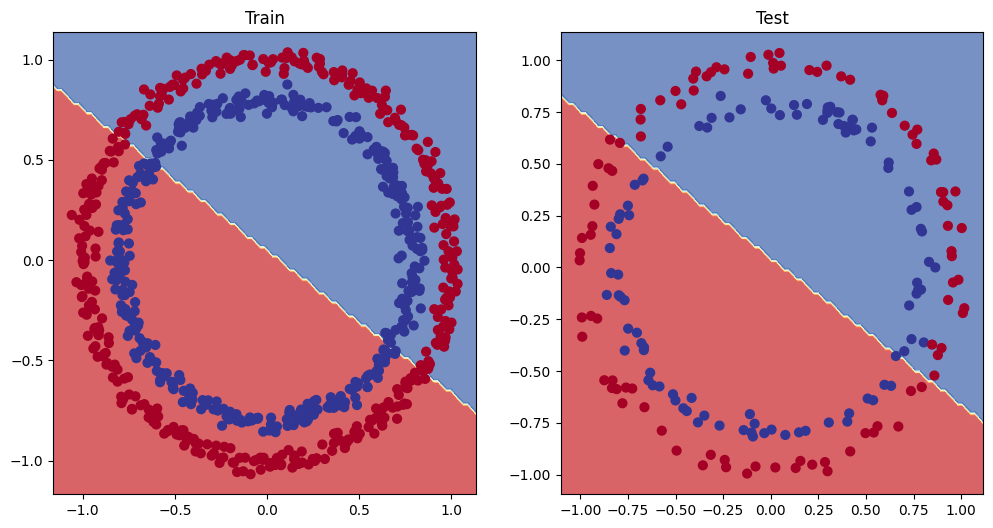

In [114]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)